# Trajectory Construction

Our goal is to reconstruct users' travel trajectories from photos with geo-tag and timestamp around Melbourne area. To do this, we use the [YFCC100M dataset](https://webscope.sandbox.yahoo.com/catalog.php?datatype=i&did=67) dataset which is a collection of photos/videos uploaded to Flickr between 2004 and 2014. 

The original YFCC100M dataset contains 100 million photos/videos and does not provide any trajectories about users. In this notebook, we will describe how we reconstruct user trajectories from the original dataset.

(*We will not distinguish a photo and video in the rest of this notebook)

**Three major steps for constructing trajectories:**

* Step 1. Extract photos taken near Melbourne area from original YFCC100M dataset (`filtering_bigbox.py`)
    * The YFCC100M dataset contains 100 million photos which requires huge computational cost to handle.
    * Since we are only interested in trajectories near Melbourne, we will extract photos near Melbourne to reduce further computational cost from next steps.
    
* Step 2. Extract candidate trajectories based on the extracted photos (`generate_tables.py`)
    * From the extracted photos in Step 1, we will reconstruct user trajectories by using _geo-tag_ and _timestamp_ of photos.
    * Basically, we group photos by user, sort the grouped photos by timestamp, and then link sequentially consecutive photos to construct trajectory
    
* Step 3. Filter out some abnormal trajectories using various criteria (`this notebook`)
    * The candidate trajectories may contain abnormal, meaningless, improbable trajectories.
    * Due to serveral reasons such as GPS errors, invalid time-stamp, 
    * In this step, we will remove those abnormal trajectories by using various criteria
    * Data cleaning/noise filtering
   
Below we will describe the details of each step with source codes.

## Table of Contents
* [Step 1. Extract relevant photos from YFCC100M dataset](#1.-Extract-relevant-points-from-YFCC100M-dataset)
    * [1.1. Basic stats of initial dataset](#1.1.-Basic-stats-of-initial-dataset)
    * [1.2. Scatter plot of extracted points](#1.2.-Scatter-plot-of-extracted-points)
* [Step 2. Extract candidate trajectories from extracted points](#Step-2.-Extract-candidate-trajectories-from-extracted-points)
    * [2.1. Basic statistics about the candidate trajectories](#2.1.-Basic-statistics-about-the-candidate-trajectories)
    * [2.2. Scatter plot of points in all candidate trajectories](#2.2.-Scatter-plot-of-points-in-all-candidate-trajectories)
* [Step 3. Filter Abnormal Trajectory](#3.-Filter-Trajectory)
    * [3.1. Filter by Travel time](#3.1.-Filter-by-travel-time)
    * [3.2. Filter by Travel distance](#3.2.-Filter-by-travel-distance)
    * [3.3. Filter by Travel Speed](#3.3.-Filter-by-travel-speed)
        * [3.3.1. Drop trajectory by average speed](#3.3.1.-Drop-trajectory-by-average-speed)
        * [3.3.2. Drop trajectory by point-to-point speed](#3.3.2.-Drop-trajectory-by-point-to-point-speed)
* [4. Final Trajectory](#4.-Filtered-Trajectory)
    * [4.1. Basic Stats](#4.1.-Basic-Stats)

### ** We place all parameters used to generate trajectories next. Modifing some parameter and rerun this notebook will generate different trajectory files**

<a id='argument_list'></a>

In [1]:
%matplotlib inline

import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import generate_tables

# data files
data_dir = '../data/'
table0 = 'Melb_photos_bigbox.csv'
table1 = 'trajectory_photos.csv'
table2 = 'trajectory_stats.csv'
raw_table = os.path.join(data_dir, table0)
photo_table = os.path.join(data_dir, table1)
traj_table = os.path.join(data_dir, table2)

# parameters for generating trajectories from extracted photos
time_gap = 8  # hour
minimum_photo = 1 # minimum number of photos for each trajectory
lng_min = 144.597363  # small bounding box
lat_min = -38.072257
lng_max = 145.360413
lat_max = -37.591764

# parameters for filtering trajectories
minimum_distance = 0.5   # km
speed_filter = 1    #(0: filter by average speed, 1: filter by point-to-point speed)
maximum_speed = 100    # km/h
maximum_duration = 1440    # minutes
minimum_duration = 30 #minute

<a id='first_step'></a>

# Step 1. Extract relevant photos from YFCC100M dataset

The original YFCC100M dataset contains 100million photos. We are only interested in user behavior near Melbourne area. Therefore, we first extract the photos belongs to the below region to reduce the further computational cost.

The latitudes and longitudes of this region is described in `data/Melbourne-bbox.kml` file. 

![big-box](./img/bigbox.png)

This process can be done by `src/filtering_bigbox.py`.

`filtering_bigbox.py` file takes the original YFCC100M file to extract photos and videos from above region as well as a time window `[2000-01-01 00:00:00, 2015-03-05 23:59:59]`, then generates a cvs file containing:

* Photo/video ID
* NSID (user ID)
* Date
* Longitude
* Latitude
* Accuracy (GPS accuracy)
* Photo/video URL
* Photo/video identifier (0 = photo, 1 = video)

The usage of this file is :
> `python filtering_bigbox.py YFCC100M_DATA_FILE`

which will generate filtered output `out.YFCC100M_DATA_FILE` file.

The original YFCC100M data files are not incorporated in this repository. But we incorporate the filtered output in `data/Melb_photos_bigbox.csv`

## 1.1. Basic stats of initial dataset

Here are some basic statistics after extracting relevant photos from the YFCC100M.

In [2]:
raw = pd.read_csv(raw_table, parse_dates=[2], skipinitialspace=True)
print('Number of photos:', raw['Photo_ID'].shape[0])
print('Number of users: ', raw['User_ID'].unique().shape[0])
raw[['Longitude', 'Latitude', 'Accuracy']].describe() 

Number of photos: 216472
Number of users:  2982


,Longitude,Latitude,Accuracy
count,216472.000000,216472.000000,216472.00000
mean,144.896785,-37.834228,14.27356
std,0.652072,0.408834,2.09961
min,141.902733,-39.284489,1.00000
25%,144.937386,-37.878579,13.00000
50%,144.967147,-37.818361,15.00000
75%,145.021247,-37.797848,16.00000
max,147.098680,-35.804727,16.00000


### 1.2. Scatter plot of extracted points

We also plot the location of extracted photos. The high density area represents the areas where a lot of photos has been taken.

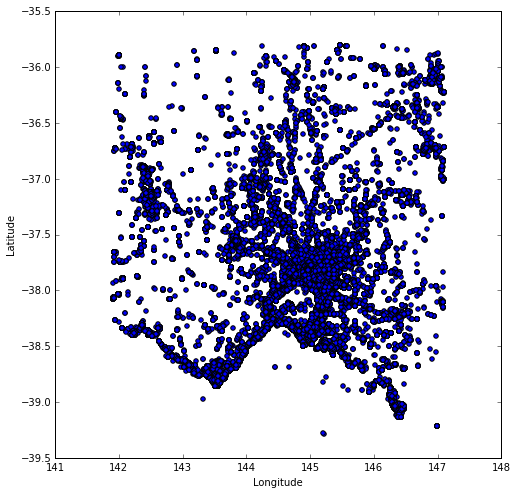

In [3]:
plt.figure(figsize=[8, 8])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(raw['Longitude'], raw['Latitude'])

# Step 2. Extract candidate trajectories from extracted points

From the extracted photos, we reconstruct user trajectories using geo-tag and timestamp of photos as follows:

* Step 2.1: Group the extracted photos by user
* Step 2.2: Sort the grouped photos by timestamp
* Step 2.3: Split the sorted photos into trajectories if the time gap between two consecutive photos is greater than 8 (\$time_gap) hours
* Step 2.4: We plot the trajectories on map. Keep trajectories at least one (\$minimum_photo) photo is taken from the central Melbourne area below. To make sure that the travel is not far from Melbourne

![small-box](./img/smallbox.png)

`src/generate_tables.py` will generate the inital trajectories using arguments.

The usage of this file is :
> `python generate_tables.py extracted_points_file lng_min lat_min lng_max lat_max minimum_photo time_gap

with arguments:

* `extracted_points_file` = the output of `src/filtering_bigbox.py`
* `lng_min` = min longitude of target region
* `lat_min` = min latitude of target region
* `lng_max` = max longtidue of target region
* `lat_max` = max latitude of targer region
* `minimum_photo` = minimum number of photos for each trajectory
* `time_gap` = Split the sorted photos into trajectories if the time gap between two consecutive photos is greater than this

In [4]:
extracted_points_file = raw_table # outputfile path of extracted points
%run generate_tables $extracted_points_file $lng_min $lat_min $lng_max $lat_max $minimum_photo $time_gap 

This will result two data files: 1 trajectory data file (\$photo table), and 2 trajectory statistic file (\$traj_table). 

> trajectory data file: each entry(line) of this file reprsents single photo with additional information about the photo:
    * Trajectory_ID: trajectory ID of entry (multiple entries belong to the same trajectory will have the same trajectory ID)
    * Photo_ID: Unique Photo ID of entry
    * User_ID: User ID
    * Timestamp: Timestamp of when the photo was taken
    * Longitude: Longitude of entry 
    * Latitude: Latitude of entry
    * Accuracy: GPS Accuracy level (16 - the most accurate, 1 - the least accurate)
    * Marker: 0 if the entry is photo, 1 if the entry is video
    * URL: flickr URL to the entry

> trajectory statistic file: each entry(line) of this file represents single trajectory with addtional information about the trajectory:
    * Trajectory_ID: Unique trajectory ID
    * User_ID: User ID
    * #Photo: Number of photos in the trajectory
    * Start_Time: When the first photo was taken
    * Travel_Distance(km): Sum of the distances between sequantially consecutive photos (Euclidean Distance)
    * Total_Time(min): The time gap between the first photo and the last photo
    * Average_Speed(km/h): Travel_Distances(km)/Total_Time(h)

We read these files by using pandas library for further processing:

In [5]:
traj = pd.read_csv(photo_table, parse_dates=[3], skipinitialspace=True)
traj_stats = pd.read_csv(traj_table, parse_dates=[3], skipinitialspace=True)

## 2.1. Basic statistics about the candidate trajectories

Here are the basic statistics about candidate trajectories from `src/generate tables.py`:

In [6]:
num_photo = traj['Photo_ID'].shape[0]
num_user = traj_stats['User_ID'].unique().shape[0]
num_traj = traj_stats['Trajectory_ID'].shape[0]
print('Number of photos:', num_photo)
print('Number of users: ', num_user)
print('Number of trajectories:', num_traj)
print('Average number of photos per user:', num_photo / num_user)
print('Average number of trajectories per user:', num_traj / num_user)

Number of photos: 151585
Number of users:  2443
Number of trajectories: 26468
Average number of photos per user: 62.0487106017192
Average number of trajectories per user: 10.834220221039706


In [7]:
traj_stats[['#Photo', 'Travel_Distance(km)', 'Total_Time(min)', 'Average_Speed(km/h)']].describe()

,#Photo,Travel_Distance(km),Total_Time(min),Average_Speed(km/h)
count,26468.000000,26468.000000,26468.000000,26468.000000
mean,5.727104,6.428739,69.438155,203.032228
std,18.028451,92.474613,147.247720,20886.528789
min,1.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000
75%,4.000000,0.137448,59.745833,0.195719
max,1340.000000,11936.856210,2488.683333,3368377.502404


## 2.2. Scatter plot of points in all candidate trajectories

We plot the location of extracted photos in the cadidate trajectories. The high density area represents the areas where a lot of photos has been taken.

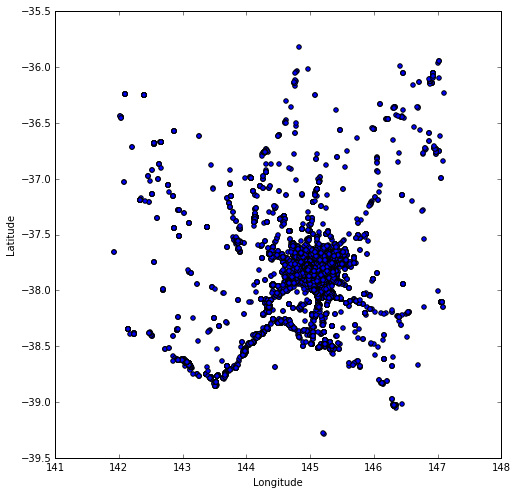

In [8]:
plt.figure(figsize=[8, 8])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(traj['Longitude'], traj['Latitude'])

## 2.3. Histograms of number of photos in trajectories, total time/distance and average speed of trajectories

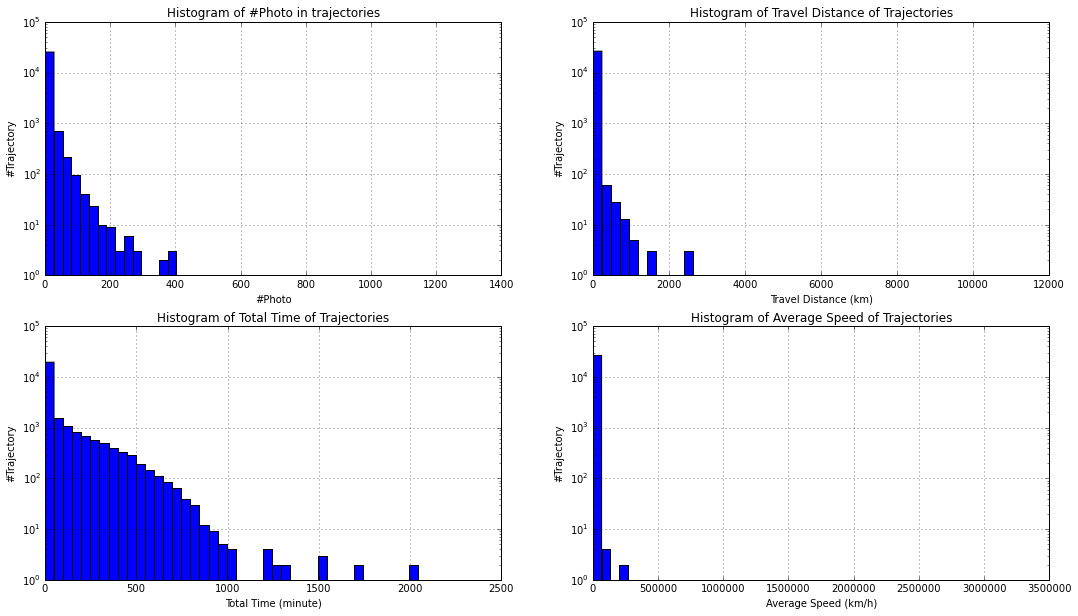

In [9]:
plt.figure(figsize=[18, 10])
plt.subplot(2,2,1)
plt.xlabel('#Photo')
plt.ylabel('#Trajectory')
plt.title('Histogram of #Photo in trajectories')
ax0 = traj_stats['#Photo'].hist(bins=50)
ax0.set_yscale('log')

plt.subplot(2,2,2)
plt.xlabel('Travel Distance (km)')
plt.ylabel('#Trajectory')
plt.title('Histogram of Travel Distance of Trajectories')
ax1 = traj_stats['Travel_Distance(km)'].hist(bins=50)
ax1.set_yscale('log')

plt.subplot(2,2,3)
plt.xlabel('Total Time (minute)')
plt.ylabel('#Trajectory')
plt.title('Histogram of Total Time of Trajectories')
ax2 = traj_stats['Total_Time(min)'].hist(bins=50)
ax2.set_yscale('log')

plt.subplot(2,2,4)
plt.xlabel('Average Speed (km/h)')
plt.ylabel('#Trajectory')
plt.title('Histogram of Average Speed of Trajectories')
ax3 = traj_stats['Average_Speed(km/h)'].hist(bins=50)
ax3.set_yscale('log')

** As these histogram indicates, there are several abnormal trajectories in this dataset. For example, some trajectories span several days, some trajectory shows improbably high speed (3500000 km/h), and travel distance of some trajectories is almost zero which might not be interesting as a travel trajectory. **

In the following section, we will provide guidelines to filter out these abnormal trajectories.

# 3. Filter Trajectory

After getting an initial list of trajectories, we further filter out improbable trajectories with various criteria.
We use four different criteria as follows:

1. **Travel time**: Some suspicious trajectory span over more than several days. We remove trajectories spanning more than several days or only few minutes. (`maximum_duration`, `minimum_duration`).
2. **Travel distance**: Trajectories consist of photos taken from single location is not meaningful as a trajectory. We remove these trajectories (`minimum_distance`)
3. **Travel speed**: Due to the GPS error, there are some trajectories in which a user moves unbelievably fast speed. We remove these trajectories, but try to recover as much information as possible from some trajectories.

The list of arguments we used to generate final trajectories are available at [the top of the notebook](#argument_list).

## 3.1. Filter by travel time

First, we filter out trajectories which have suspiciously long or short travel times. We want to see the one-day long travel trajectories of users, and also want to avoid the trajectory that are captured in very short time.

In this step, we filtered out the trajectories of which travel time is greather than maximum_duration or less than minimum_duration.

In [10]:
traj_stats1 = traj_stats[traj_stats['Total_Time(min)'] < maximum_duration]
traj_stats1 = traj_stats1[traj_stats1['Total_Time(min)'] > minimum_duration]
traj1 = traj[traj['Trajectory_ID'].isin(traj_stats1['Trajectory_ID'])]

### 3.1.1. Histogram of travel time

Here's the histogram of travel time before and after filtering. We removed several trajectories of which travel time is less than 30 min and greater than 24 hours.

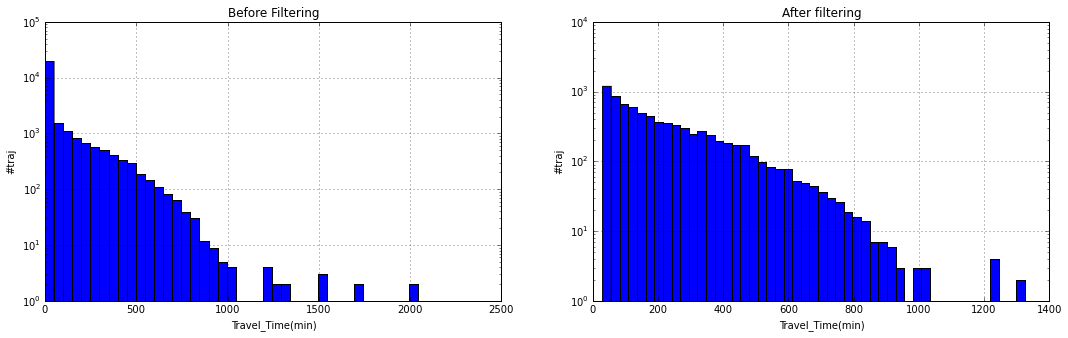

In [11]:
plt.figure(figsize=[18, 5])
plt.subplot(1,2,1)
plt.xlabel('Travel_Time(min)')
plt.ylabel('#traj')
plt.title('Before Filtering')
ax0 = traj_stats['Total_Time(min)'].hist(bins=50)
ax0.set_yscale('log')

plt.subplot(1,2,2)
plt.xlabel('Travel_Time(min)')
plt.ylabel('#traj')
plt.title('After filtering')
ax1 = traj_stats1['Total_Time(min)'].hist(bins=50)
ax1.set_yscale('log')

##  3.2. Filter by travel distance

To be a meaningful trajectory, the travel distance of trajactory spans at least several hundred meters. Extremely short travel distance only shows the interesting area where the photo has been taken.

To get the trajectory, we filter out the trajectories of which travel distance is less than minimum_distance.

In [12]:
traj_stats2 = traj_stats1[traj_stats1['Travel_Distance(km)'] > minimum_distance]
traj2 = traj[traj['Trajectory_ID'].isin(traj_stats2['Trajectory_ID'])]

### 3.2.1. Histogram of trajectory length

Here's the histogram of travel distances before and after filtering. Trajectories with very short travel distance has been removed from our dataset.

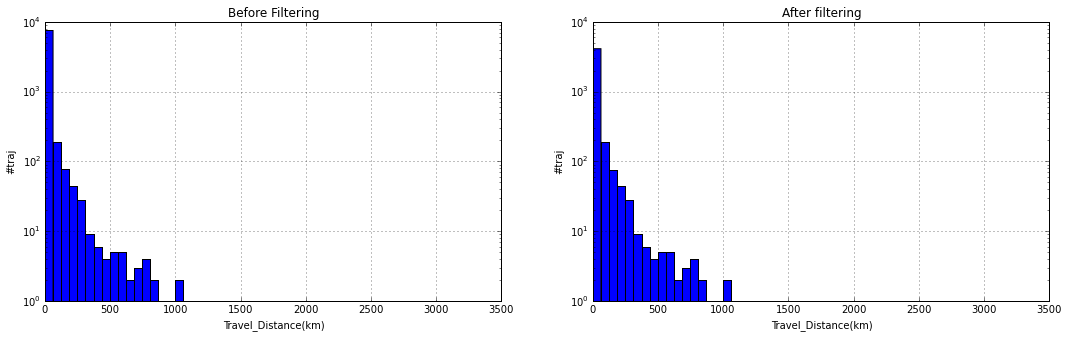

In [13]:
plt.figure(figsize=[18, 5])
plt.subplot(1,2,1)
plt.xlabel('Travel_Distance(km)')
plt.ylabel('#traj')
plt.title('Before Filtering')
ax1 = traj_stats1['Travel_Distance(km)'].hist(bins=50)
ax1.set_yscale('log')

plt.subplot(1,2,2)
plt.xlabel('Travel_Distance(km)')
plt.ylabel('#traj')
plt.title('After filtering')
ax2 = traj_stats2['Travel_Distance(km)'].hist(bins=50)
ax2.set_yscale('log')

In [14]:
traj_stats_new = traj_stats2
traj_new = traj2

## 3.3. Filter by travel speed

Some trajectories have suspiciously high speed. It may caused by various reasons. For example, errors in GPS system or errors in time stampmight yeild super sonic users. 

There are two (or more) alternative ways to filter out trajectory which has suspiciously high speed.

Here, we provide two filtering method: (the *switch* to use one of the methods can be set at [the top of the notebook](#argument_list))

1. [Filtered by average speed](#3.4.1.-Drop-trajectory-by-average-speed)
2. [Filtered by speed of adjacency points](#3.4.2.-Drop-trajectory-by-point-to-point-speed)

### 3.3.1. Drop trajectory by average speed

We check average speed of every trajectory, and then throw out all trajectories of which average speed is less than predefined maximum_speed

In [15]:
if speed_filter == 0:
    traj_stats_new = traj_stats_new[traj_stats_new['Average_Speed(km/h)'] < maximum_speed]
    traj_new = traj_new[traj_new['Trajectory_ID'].isin(traj_stats_new['Trajectory_ID'])]

#### 3.4.1.1. Histogram of trajectory speed

In [16]:
if speed_filter == 0:
    plt.figure(figsize=[18, 5])
    plt.subplot(1,2,1)
    plt.xlabel('Average_Speed(km/h)')
    plt.ylabel('#traj')
    ax = traj_stats_new['Average_Speed(km/h)'].hist(bins=50)
    ax.set_yscale('log')

### 3.3.2. Drop trajectory by point-to-point speed

The first approach might be inefficient when the improbable speed occurs by GPS calibration error. To keep as much information as possible, we propose more sophisticated method to recover information from abnormal trajectories.

There are four cases of improbably fast trajectory might be happened

1. The first point of trajectory is far away from the rest of the trajectory (GPS calibrating/entering building etc..)
2. The last point of trajectory is far away from the rest of the trajectory
3. One or more middle points of trajectory are far way from the rest of the trajectory (GPS error)
4. Mixture of previous three cases

The first and second cases are easy to recover by cutting the corresponding point. But it seems we could not easily decide which point(s) should be cut for third and fourth cases. We've decided to remove trajectories in case 3 and 4.


Compute point-to-point speed before filtering

In [17]:
speeds = []
if speed_filter == 1:   
    for tid in traj_stats_new['Trajectory_ID']:
        photos = traj_new[traj_new['Trajectory_ID'] == tid]
        if photos.shape[0] < 2: continue
        for i in range(len(photos.index)-1):
            idx1 = photos.index[i]
            idx2 = photos.index[i+1]
            dist = generate_tables.calc_dist(photos.loc[idx1, 'Longitude'], photos.loc[idx1, 'Latitude'], \
                                             photos.loc[idx2, 'Longitude'], photos.loc[idx2, 'Latitude'])
            seconds = (photos.loc[idx1, 'Timestamp'] - photos.loc[idx2, 'Timestamp']).total_seconds()
            if seconds == 0: continue
            speed = dist * 60. * 60. / abs(seconds)
            speeds.append(speed)

Histogram of point-to-point speed before filtering

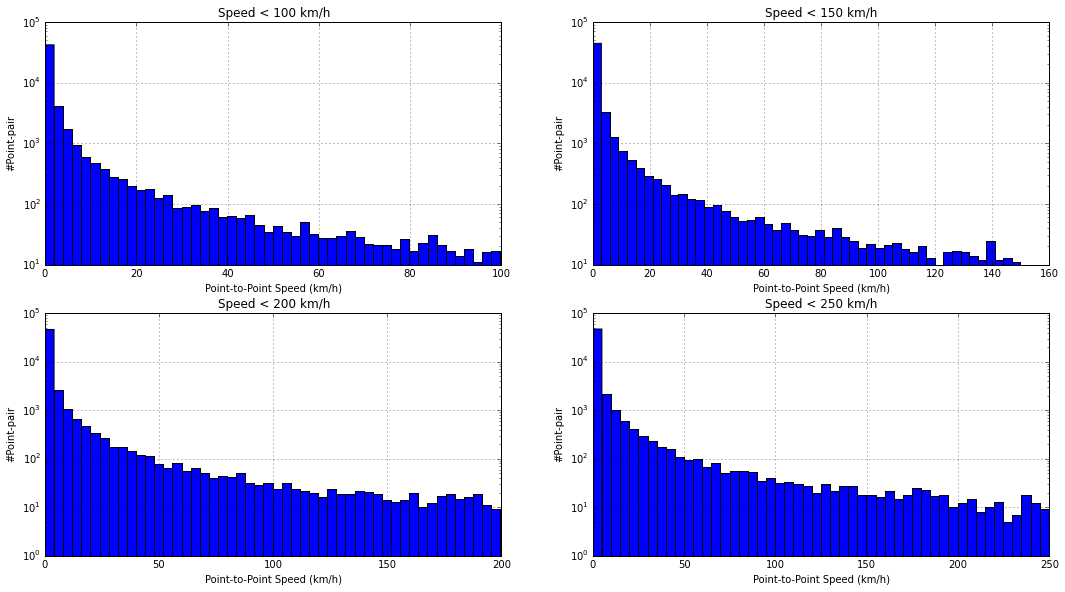

In [18]:
#S = [100, 150, 200, 250, 500, 1000, 1236, 100000]
S = [100, 150, 200, 250] 
if speed_filter == 1:
    p2pspeeds = pd.Series(speeds)
    plt.figure(figsize=[18,20])
    for it in range(len(S)):
        plt.subplot(4,2,it+1)
        plt.xlabel('Point-to-Point Speed (km/h)')
        plt.ylabel('#Point-pair')
        plt.title('Speed < ' + str(S[it]) + ' km/h')
        ax = p2pspeeds[p2pspeeds < S[it]].hist(bins=50)
        ax.set_yscale('log')

Drop the first/last point in a trajectories for case1/case2, drop enter trajectories for case3 and case4

In [19]:
if speed_filter == 1:
    # raise an exception if assigning value to a copy (instead of the original data) of DataFrame
    pd.set_option('mode.chained_assignment','raise') 
    traj_stats_new = traj_stats_new.copy()
    traj_new = traj_new.copy()

    indicator_traj = pd.Series(data=np.ones(traj_stats_new.shape[0], dtype=np.bool), index=traj_stats_new.index)
    indicator_photo = pd.Series(data=np.ones(traj_new.shape[0], dtype=np.bool), index=traj_new.index)
    cnt1 = 0
    cnt2 = 0
    cnt34 = 0
    for i in traj_stats_new['Trajectory_ID'].index:
        tid = traj_stats_new.loc[i, 'Trajectory_ID']
        photos = traj_new[traj_new['Trajectory_ID'] == tid]
        if photos.shape[0] <= 2:
            if traj_stats_new.loc[i, 'Average_Speed(km/h)'] > maximum_speed: # drop the trajectory
                indicator_traj.loc[i] = False
                indicator_photo.loc[photos.index] = False
            continue
        # trajectory: 1-->2-->...-->3-->4, 2 and 3 could be the same
        idx1 = photos.index[0]
        idx2 = photos.index[1]
        idx3 = photos.index[-2]
        idx4 = photos.index[-1]
        d12 = generate_tables.calc_dist(photos.loc[idx1, 'Longitude'], photos.loc[idx1, 'Latitude'], \
                                        photos.loc[idx2, 'Longitude'], photos.loc[idx2, 'Latitude'])
        d24 = traj_stats_new.loc[i, 'Travel_Distance(km)'] - d12
        t12 = abs((photos.loc[idx1, 'Timestamp'] - photos.loc[idx2, 'Timestamp']).total_seconds())
        t24 = abs((photos.loc[idx2, 'Timestamp'] - photos.loc[idx4, 'Timestamp']).total_seconds())
        # check case 1
        if t12 == 0 or (d12 * 60. * 60. / t12) > maximum_speed: #photo1-->photo2, inf speed or large speed
            if t24 == 0 or abs(d24) < 1e-3 or (d24 * 60. * 60. / t24) > maximum_speed: # drop the trajectory
                indicator_traj.loc[i] = False
                indicator_photo.loc[photos.index] = False
                continue
            else: # case 1, drop the first photo, update trajectory statistics
                assert(d24 > 0.)
                #traj_stats.ix[i]['Start_Time'] = photos.ix[idx2]['Timestamp'] # SettingWithCopyWarning
                indicator_photo.loc[idx1] = False
                traj_stats_new.loc[i, 'Start_Time'] = photos.loc[idx2, 'Timestamp']
                traj_stats_new.loc[i, 'Travel_Distance(km)'] = d24
                traj_stats_new.loc[i, 'Total_Time(min)'] = t24 / 60.
                traj_stats_new.loc[i, 'Average_Speed(km/h)'] = d24 * 60. * 60. / t24
                cnt1 += 1
                continue
        # check case 2
        d34 = generate_tables.calc_dist(photos.loc[idx3, 'Longitude'], photos.loc[idx3, 'Latitude'], \
                                        photos.loc[idx4, 'Longitude'], photos.loc[idx4, 'Latitude'])
        d13 = traj_stats_new.loc[i, 'Travel_Distance(km)'] - d34
        t34 = abs((photos.loc[idx3, 'Timestamp'] - photos.loc[idx4, 'Timestamp']).total_seconds())
        t13 = abs((photos.loc[idx1, 'Timestamp'] - photos.loc[idx3, 'Timestamp']).total_seconds())
        if t34 == 0 or (d34 * 60. * 60. / t34) > maximum_speed: #photo3-->photo4, inf speed or large speed
            if t13 == 0 or abs(d13) < 1e-3 or (d13 * 60. * 60. / t13) > maximum_speed: # drop the trajectory
                indicator_traj.loc[i] = False
                indicator_photo.loc[photos.index] = False
                continue
            else: # case 2, drop the last photo, update trajectory statistics
                assert(d13 > 0.)
                #traj_stats.ix[i]['Travel_Distance(km)'] = d13 # SettingWithCopyWarning
                indicator_photo.loc[idx4] = False
                traj_stats_new.loc[i, 'Travel_Distance(km)'] = d13
                traj_stats_new.loc[i, 'Total_Time(min)'] = d13 / 60.
                traj_stats_new.loc[i, 'Average_Speed(km/h)'] = d13 * 60. * 60. / t13
                cnt2 += 1
                continue
            
        # case 3 or 4, drop trajectory
        if traj_stats_new.loc[i, 'Average_Speed(km/h)'] > maximum_speed:
            indicator_traj.loc[i] = False
            indicator_photo.loc[photos.index] = False
            cnt34 += 1
    
    print('Number of trajectories in case 1:', cnt1)
    print('Number of trajectories in case 2:', cnt2)
    print('Number of trajectories in case 3 & 4:', cnt34)

    traj_new = traj_new[indicator_photo]
    traj_stats_new = traj_stats_new[indicator_traj]

Number of trajectories in case 1: 93
Number of trajectories in case 2: 97
Number of trajectories in case 3 & 4: 13


Compute point-to-point speed after filtering

In [20]:
speeds_new = []
if speed_filter == 1:
    for tid in traj_stats_new['Trajectory_ID']:
        photos = traj_new[traj_new['Trajectory_ID'] == tid]
        if photos.shape[0] < 2: continue
        for i in range(len(photos.index)-1):
            idx1 = photos.index[i]
            idx2 = photos.index[i+1]
            dist = generate_tables.calc_dist(photos.loc[idx1, 'Longitude'], photos.loc[idx1, 'Latitude'], \
                                             photos.loc[idx2, 'Longitude'], photos.loc[idx2, 'Latitude'])
            seconds = (photos.loc[idx1, 'Timestamp'] - photos.loc[idx2, 'Timestamp']).total_seconds()
            if seconds == 0: continue
            speed = dist * 60. * 60. / abs(seconds)
            speeds_new.append(speed)

Histogram of point-to-point speed after filtering

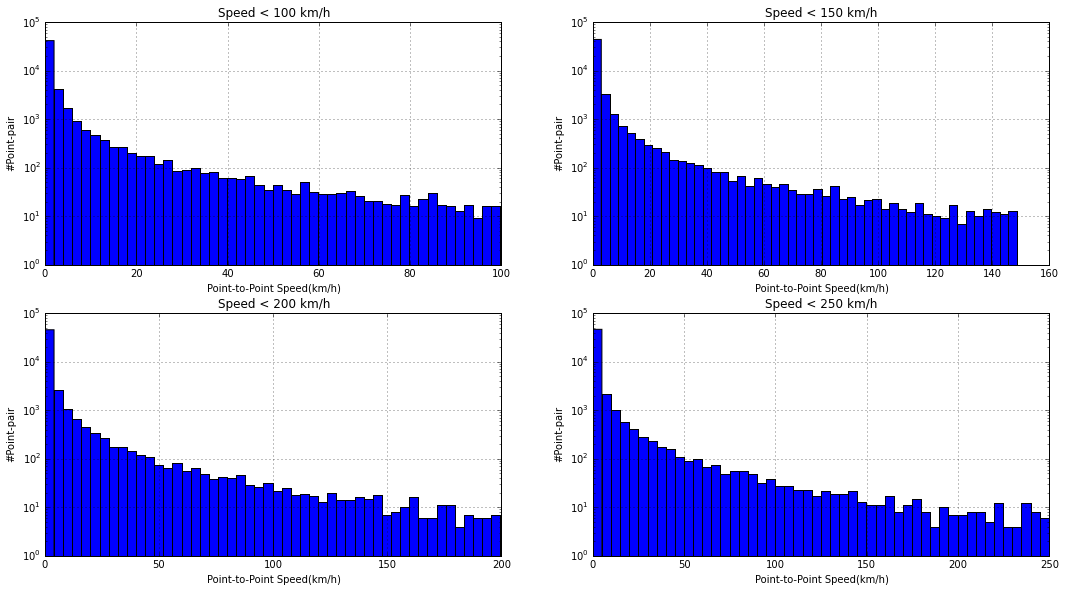

In [21]:
#S = [100, 150, 200, 250, 500, 1000, 1236, 100000]
S = [100, 150, 200, 250]
if speed_filter == 1:
    p2pspeeds_new = pd.Series(speeds_new)
    plt.figure(figsize=[18,20])
    for it in range(len(S)):
        plt.subplot(4,2,it+1)
        plt.xlabel('Point-to-Point Speed(km/h)')
        plt.ylabel('#Point-pair')
        plt.title('Speed < ' + str(S[it]) + ' km/h')
        ax = p2pspeeds_new[p2pspeeds_new < S[it]].hist(bins=50)
        ax.set_yscale('log')

# 4. Final Trajectory

In this section, we will show some basic statistics about our final trajectory data.

## 4.1. Basic Stats

More detail analysis will be included in [`filckr_analysis.ipynb`](https://github.com/arongdari/flickr-photo/blob/master/src/flickr_analysis.ipynb) and slides. Here we show simple stats from the final result.

In [22]:
num_photo = traj_new['Photo_ID'].shape[0]
num_user = traj_stats_new['User_ID'].unique().shape[0]
num_traj = traj_stats_new['Trajectory_ID'].shape[0]
print('Number of photos:', num_photo)
print('Number of users: ', num_user)
print('Number of trajectories:', num_traj)
print('Average number of photos per user:', num_photo / num_user)
print('Average number of trajectories per user:', num_traj / num_user)

Number of photos: 58146
Number of users:  977
Number of trajectories: 4460
Average number of photos per user: 59.51484135107472
Average number of trajectories per user: 4.564994882292733


In [23]:
traj_stats_new[['#Photo', 'Travel_Distance(km)', 'Total_Time(min)', 'Average_Speed(km/h)']].describe()

,#Photo,Travel_Distance(km),Total_Time(min),Average_Speed(km/h)
count,4460.000000,4460.000000,4460.000000,4460.000000
mean,13.079821,18.972181,259.316410,4.786399
std,22.568952,51.374009,194.903194,10.335970
min,2.000000,0.099699,0.001662,0.043375
25%,3.000000,1.538369,99.975000,0.575029
50%,6.000000,4.352130,215.566667,1.340931
75%,13.000000,13.241969,371.912500,3.850646
max,379.000000,867.034519,1351.083333,98.850612


**Histograms of number of photos in trajectories, total time/distance and average speed of trajectories**

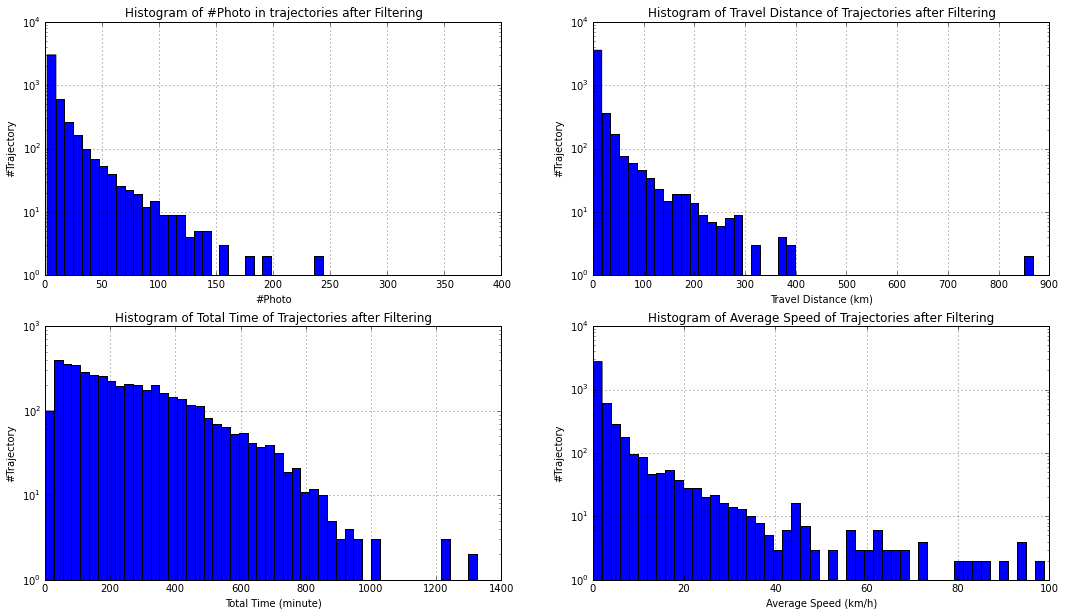

In [24]:
plt.figure(figsize=[18, 10])
plt.subplot(2,2,1)
plt.xlabel('#Photo')
plt.ylabel('#Trajectory')
plt.title('Histogram of #Photo in trajectories after Filtering')
ax0 = traj_stats_new['#Photo'].hist(bins=50)
ax0.set_yscale('log')

plt.subplot(2,2,2)
plt.xlabel('Travel Distance (km)')
plt.ylabel('#Trajectory')
plt.title('Histogram of Travel Distance of Trajectories after Filtering')
ax1 = traj_stats_new['Travel_Distance(km)'].hist(bins=50)
ax1.set_yscale('log')

plt.subplot(2,2,3)
plt.xlabel('Total Time (minute)')
plt.ylabel('#Trajectory')
plt.title('Histogram of Total Time of Trajectories after Filtering')
ax2 = traj_stats_new['Total_Time(min)'].hist(bins=50)
ax2.set_yscale('log')

plt.subplot(2,2,4)
plt.xlabel('Average Speed (km/h)')
plt.ylabel('#Trajectory')
plt.title('Histogram of Average Speed of Trajectories after Filtering')
ax3 = traj_stats_new['Average_Speed(km/h)'].hist(bins=50)
ax3.set_yscale('log')

**Save final trajectories to the data folder**

In [25]:
file1 = os.path.join(data_dir + table1)
file2 = os.path.join(data_dir + table2)
traj_new.to_csv(file1, index=False)
traj_stats_new.to_csv(file2, index=False)